**Общая информация**

**Срок сдачи:** 18 октября 2017, 06:00 <br\>
**Штраф за опоздание:** -2 балла после 06:00 18 октября, -4 балла после 06:00 25 октября, -6 баллов после 06:00 1 ноября

При отправлении ДЗ указывайте фамилию в названии файла
Присылать ДЗ необходимо в виде ссылки на свой github репозиторий в slack @alkhamush

Необходимо в slack создать таск в приватный чат:
/todo Фамилия Имя ссылка на гитхаб @alkhamush
Пример:
/todo Ксения Стройкова https://github.com/stroykova/spheremailru/stroykova_hw1.ipynb @alkhamush
Дополнительно нужно просто скинуть ссылку в slack в личный чат

Используйте данный Ipython Notebook при оформлении домашнего задания.

###### Задание 1 (2 баллов)
Реализовать KNN в классе MyKNeighborsClassifier (обязательное условие: точность не ниже sklearn реализации)
Разберитесь самостоятельно, какая мера расстояния используется в KNeighborsClassifier дефолтно и реализуйте свой алгоритм именно с этой мерой. Самостоятельно разберитесь, как считается score из KNeighborsClassifier и реализуйте аналог в своём классе. Score не должен уступать значению KNN из sklearn

###### Задание 2 (2 балла)
Добиться скорости работы на fit,  predict и predict_proba сравнимой со sklearn для iris и mnist
Для этого используем numpy

###### Задание 3 (2 балла)
Для iris найдите такой параметр n_neighbors, при котором выдаётся наилучший score. Нарисуйте график зависимости score от n_neighbors

###### Задание 4 (3 балла)
Добавить algorithm='kd_tree' в реализацию KNN (использовать KDTree из sklearn.neighbors). Значение n_neighbors нужно взять из задания 3. Добиться скорости работы на fit,  predict и predict_proba сравнимой со sklearn для iris и mnist
Для этого используем numpy. Score не должен уступать значению KNN из sklearn

###### Задание 5 (1 балла)
Описать для чего нужны следующие библиотеки/классы/функции (список будет ниже)

**Штрафные баллы:**

1. Невыполнение PEP8 -1 балл
2. Отсутствие фамилии в имени скрипта (скрипт должен называться по аналогии со stroykova_hw1.ipynb) -1 балл
3. Все строчки должны быть выполнены. Нужно, чтобы output команды можно было увидеть уже в git'е. В противном случае -1 балл
4. При оформлении ДЗ нужно пользоваться данным файлом в качестве шаблона. Не нужно удалять и видоизменять структуру кода и текст. В противном случае -1 балл


In [1]:
import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns
from sklearn import datasets
from sklearn.base import ClassifierMixin
from sklearn.datasets import fetch_mldata
from sklearn.neighbors.base import NeighborsBase, KNeighborsMixin, SupervisedIntegerMixin 
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import KDTree
%load_ext pycodestyle_magic

In [2]:
#%%pycodestyle


class MyKNeighborsClassifier(NeighborsBase, KNeighborsMixin,
                             SupervisedIntegerMixin, ClassifierMixin):

    def __init__(self, n_neighbors, algorithm='brute'):
        self.n_neighbors = n_neighbors
        self.algorithm = algorithm

    def fit(self, X, y):
        self.X_train = np.array(X).astype(float)
        self.y_train = np.array(y).astype(int)
        self.classes = np.unique(y).astype(int)
        self.num_of_classes = np.size(self.classes)
        if self.algorithm == 'brute':
            self.X_train_sqr = (self.X_train**2).sum(axis=1)
        if self.algorithm == 'kd_tree':
            self.tree = KDTree(X, leaf_size=30)

    def predict(self, X):
        X = np.array(X).astype(float)
        y_predicted = np.zeros(len(X)).astype(int)
        if self.algorithm == 'brute':
            X_sqr = (X**2).sum(axis=1)
            distances = -2*np.dot(X, self.X_train.T)+np.tile(
                X_sqr, (len(self.X_train), 1)).T+np.tile(
                self.X_train_sqr, (len(X), 1))
            for i in range(len(X)):
                indexes = np.argsort(distances[i, ])[:self.n_neighbors]
                y_predicted[i] = np.argmax(np.bincount(self.y_train[indexes]))
        if self.algorithm == 'kd_tree':
            distances, indexes = self.tree.query(X, k=self.n_neighbors)
            for i in range(len(X)):
                y_predicted[i] = np.argmax(
                    np.bincount(self.y_train[indexes[i]]))
        return y_predicted

    def predict_proba(self, X):
        X = np.array(X).astype(float)
        y_probs = np.zeros((len(X), self.num_of_classes))
        if self.algorithm == 'brute':
            X_sqr = (X**2).sum(axis=1)
            distances = -2*np.dot(X, self.X_train.T)+np.tile(
                X_sqr, (len(self.X_train), 1)).T+np.tile(
                self.X_train_sqr, (len(X), 1))
            for i in range(len(X)):
                indexes = np.argsort(distances[i, ])[:self.n_neighbors]
                count = np.bincount(self.y_train[indexes])
                y_probs[i, ] = np.append(count, np.zeros(
                    np.max(self.classes)-len(count)+1)) / self.n_neighbors
        if self.algorithm == 'kd_tree':
            distances, indexes = self.tree.query(X, k=self.n_neighbors)
            for i in range(len(X)):
                count = np.bincount(self.y_train[indexes[i]])
                y_probs[i, ] = np.append(count, np.zeros(
                    np.max(self.classes)-len(count)+1)) / self.n_neighbors
        return y_probs

    def score(self, X, y):
        return np.average(y == self.predict(X))

**IRIS**

In [3]:
iris = datasets.load_iris()

In [4]:
X_train, X_test, y_train, y_test = train_test_split(
    iris.data, iris.target, test_size=0.1, stratify=iris.target)

In [5]:
clf = KNeighborsClassifier(n_neighbors=2, algorithm='brute')
my_clf = MyKNeighborsClassifier(n_neighbors=2, algorithm='brute')

In [6]:
%time clf.fit(X_train, y_train)

Wall time: 995 µs


KNeighborsClassifier(algorithm='brute', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=2, p=2,
           weights='uniform')

In [7]:
%time my_clf.fit(X_train, y_train)

Wall time: 996 µs


In [8]:
%time clf.predict(X_test)

Wall time: 220 ms


array([2, 1, 2, 1, 0, 1, 0, 0, 2, 2, 1, 0, 1, 2, 0])

In [9]:
%time my_clf.predict(X_test)

Wall time: 997 µs


array([2, 1, 2, 1, 0, 1, 0, 0, 2, 2, 1, 0, 1, 2, 0])

In [10]:
%time clf.predict_proba(X_test)

Wall time: 2 ms


array([[0., 0., 1.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 1., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [1., 0., 0.]])

In [11]:
%time my_clf.predict_proba(X_test)

Wall time: 1.99 ms


array([[0., 0., 1.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 1., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [1., 0., 0.]])

In [12]:
clf.score(X_test, y_test)

1.0

In [13]:
my_clf.score(X_test, y_test)

1.0

Задание 3

The best num of neighbors is 14


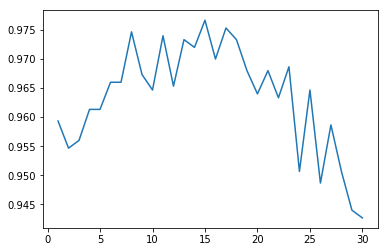

In [14]:
score = np.zeros(30)

for i in range(30):
    my_clf = MyKNeighborsClassifier(n_neighbors=i+1)
    for j in range(100):
        X_train, X_test, y_train, y_test = train_test_split(
            iris.data, iris.target,
            test_size=0.1, stratify=iris.target)
        my_clf.fit(X_train, y_train)
        score[i] = score[i] + my_clf.score(X_test, y_test)/100
print("The best num of neighbors is {}".format(np.argmax(score)))
plt.plot(range(1, 31), score)

**MNIST**

In [15]:
mnist = fetch_mldata('MNIST original')

In [16]:
X_train, X_test, y_train, y_test = train_test_split(
    mnist.data, mnist.target,
    test_size=0.01, stratify=mnist.target)

In [17]:
clf = KNeighborsClassifier(n_neighbors=2, algorithm='brute')
my_clf = MyKNeighborsClassifier(n_neighbors=2, algorithm='brute')

In [18]:
%time clf.fit(X_train, y_train)

Wall time: 8.99 ms


KNeighborsClassifier(algorithm='brute', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=2, p=2,
           weights='uniform')

In [19]:
%time my_clf.fit(X_train, y_train)

Wall time: 497 ms


In [20]:
%time clf.predict(X_test)

Wall time: 2.25 s


array([7., 3., 3., 1., 1., 2., 1., 3., 7., 4., 4., 1., 6., 8., 2., 3., 4.,
       1., 7., 2., 2., 3., 5., 6., 1., 6., 5., 5., 6., 2., 7., 2., 7., 9.,
       8., 8., 1., 5., 6., 8., 8., 1., 4., 2., 6., 3., 4., 7., 2., 7., 3.,
       2., 8., 9., 7., 0., 4., 2., 1., 0., 4., 3., 9., 4., 4., 2., 4., 9.,
       8., 0., 8., 6., 9., 9., 5., 0., 5., 5., 1., 6., 0., 1., 1., 3., 0.,
       8., 3., 7., 3., 1., 6., 0., 9., 2., 0., 8., 5., 8., 1., 0., 1., 7.,
       8., 4., 9., 4., 1., 8., 0., 7., 6., 1., 2., 8., 0., 1., 0., 5., 4.,
       7., 3., 5., 0., 5., 5., 0., 4., 5., 2., 2., 6., 5., 3., 4., 8., 4.,
       5., 9., 6., 6., 0., 0., 5., 0., 8., 5., 1., 8., 9., 8., 0., 9., 8.,
       6., 9., 0., 3., 6., 8., 2., 3., 4., 5., 9., 0., 0., 9., 5., 4., 4.,
       2., 1., 8., 6., 2., 5., 6., 0., 4., 8., 1., 6., 6., 0., 5., 8., 5.,
       0., 9., 4., 1., 5., 1., 5., 7., 2., 4., 8., 6., 7., 3., 5., 3., 2.,
       9., 2., 4., 9., 0., 6., 6., 7., 4., 7., 6., 7., 7., 1., 0., 1., 5.,
       9., 8., 4., 1., 6.

In [21]:
%time my_clf.predict(X_test)

Wall time: 7.42 s


array([7, 3, 3, 1, 1, 2, 1, 3, 7, 4, 4, 1, 6, 8, 2, 3, 4, 1, 7, 2, 2, 3,
       5, 6, 1, 6, 5, 5, 6, 2, 7, 2, 7, 9, 8, 8, 1, 5, 6, 8, 8, 1, 4, 2,
       6, 3, 4, 7, 2, 7, 3, 2, 8, 9, 7, 0, 4, 2, 1, 0, 4, 3, 9, 4, 4, 2,
       4, 9, 8, 0, 8, 6, 9, 9, 5, 0, 5, 5, 1, 6, 0, 1, 1, 3, 0, 8, 3, 7,
       3, 1, 6, 0, 9, 2, 0, 8, 5, 8, 1, 0, 1, 7, 8, 4, 9, 4, 1, 8, 0, 7,
       6, 1, 2, 8, 0, 1, 0, 5, 4, 7, 3, 5, 0, 5, 5, 0, 4, 5, 2, 2, 6, 5,
       3, 4, 8, 4, 5, 9, 6, 6, 0, 0, 5, 0, 8, 5, 1, 8, 9, 8, 0, 9, 8, 6,
       9, 0, 3, 6, 8, 2, 3, 4, 5, 9, 0, 0, 9, 5, 4, 4, 2, 1, 8, 6, 2, 5,
       6, 0, 4, 8, 1, 6, 6, 0, 5, 8, 5, 0, 9, 4, 1, 5, 1, 5, 7, 2, 4, 8,
       6, 7, 3, 5, 3, 2, 9, 2, 4, 9, 0, 6, 6, 7, 4, 7, 6, 7, 7, 1, 0, 1,
       5, 9, 8, 4, 1, 6, 9, 7, 3, 1, 9, 4, 4, 3, 7, 6, 1, 0, 1, 9, 7, 8,
       6, 1, 3, 3, 9, 8, 8, 8, 4, 4, 4, 1, 4, 7, 1, 2, 2, 6, 0, 5, 7, 4,
       1, 8, 7, 1, 3, 7, 2, 2, 1, 1, 3, 8, 6, 7, 3, 8, 2, 6, 0, 1, 5, 5,
       9, 4, 3, 1, 4, 7, 8, 6, 6, 6, 8, 5, 4, 9, 2,

In [22]:
%time clf.predict_proba(X_test)

Wall time: 2.51 s


array([[0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [23]:
%time my_clf.predict_proba(X_test)

Wall time: 7.46 s


array([[0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [24]:
clf.score(X_test, y_test)

0.9728571428571429

In [25]:
my_clf.score(X_test, y_test)

0.9728571428571429

Задание 4

In [26]:
clf = KNeighborsClassifier(n_neighbors=2, algorithm='kd_tree')
my_clf = MyKNeighborsClassifier(n_neighbors=2, algorithm='kd_tree')

In [27]:
X_train, X_test, y_train, y_test = train_test_split(
    mnist.data, mnist.target,
    test_size=0.01, stratify=mnist.target)

In [28]:
%time clf.fit(X_train, y_train)

Wall time: 35.2 s


KNeighborsClassifier(algorithm='kd_tree', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=2, p=2,
           weights='uniform')

In [29]:
%time my_clf.fit(X_train, y_train)

Wall time: 34.9 s


In [30]:
%time clf.predict(X_test)

Wall time: 1min 16s


array([5., 9., 2., 3., 0., 1., 9., 8., 1., 7., 2., 6., 5., 0., 8., 3., 3.,
       7., 1., 3., 0., 4., 7., 4., 3., 6., 6., 8., 5., 2., 4., 1., 9., 8.,
       3., 1., 2., 3., 5., 1., 0., 5., 3., 0., 7., 2., 4., 2., 7., 3., 1.,
       9., 3., 9., 2., 1., 2., 6., 7., 4., 3., 6., 4., 3., 9., 4., 3., 4.,
       8., 1., 4., 6., 4., 0., 3., 8., 7., 1., 4., 9., 5., 8., 0., 3., 2.,
       9., 0., 2., 8., 3., 1., 4., 4., 8., 1., 7., 7., 2., 8., 1., 9., 0.,
       6., 9., 9., 0., 3., 9., 7., 7., 7., 9., 1., 3., 1., 9., 7., 9., 3.,
       8., 1., 4., 2., 0., 4., 3., 9., 0., 2., 7., 8., 4., 6., 0., 9., 4.,
       8., 0., 4., 1., 8., 2., 1., 1., 2., 4., 0., 7., 8., 3., 2., 2., 3.,
       2., 1., 6., 3., 1., 3., 8., 4., 7., 3., 6., 8., 9., 5., 9., 5., 5.,
       3., 6., 5., 0., 1., 0., 4., 0., 7., 3., 0., 1., 5., 9., 6., 7., 7.,
       7., 9., 1., 2., 6., 5., 1., 0., 3., 5., 4., 9., 4., 3., 2., 4., 5.,
       2., 0., 8., 6., 7., 7., 1., 0., 2., 7., 5., 1., 7., 9., 2., 1., 6.,
       4., 1., 6., 1., 0.

In [31]:
%time my_clf.predict(X_test)

Wall time: 1min 16s


array([5, 9, 2, 3, 0, 1, 9, 8, 1, 7, 2, 6, 5, 0, 8, 3, 3, 7, 1, 3, 0, 4,
       7, 4, 3, 6, 6, 8, 5, 2, 4, 1, 9, 8, 3, 1, 2, 3, 5, 1, 0, 5, 3, 0,
       7, 2, 4, 2, 7, 3, 1, 9, 3, 9, 2, 1, 2, 6, 7, 4, 3, 6, 4, 3, 9, 4,
       3, 4, 8, 1, 4, 6, 4, 0, 3, 8, 7, 1, 4, 9, 5, 8, 0, 3, 2, 9, 0, 2,
       8, 3, 1, 4, 4, 8, 1, 7, 7, 2, 8, 1, 9, 0, 6, 9, 9, 0, 3, 9, 7, 7,
       7, 9, 1, 3, 1, 9, 7, 9, 3, 8, 1, 4, 2, 0, 4, 3, 9, 0, 2, 7, 8, 4,
       6, 0, 9, 4, 8, 0, 4, 1, 8, 2, 1, 1, 2, 4, 0, 7, 8, 3, 2, 2, 3, 2,
       1, 6, 3, 1, 3, 8, 4, 7, 3, 6, 8, 9, 5, 9, 5, 5, 3, 6, 5, 0, 1, 0,
       4, 0, 7, 3, 0, 1, 5, 9, 6, 7, 7, 7, 9, 1, 2, 6, 5, 1, 0, 3, 5, 4,
       9, 4, 3, 2, 4, 5, 2, 0, 8, 6, 7, 7, 1, 0, 2, 7, 5, 1, 7, 9, 2, 1,
       6, 4, 1, 6, 1, 0, 4, 0, 4, 6, 9, 1, 7, 0, 7, 2, 3, 9, 7, 0, 2, 1,
       0, 4, 4, 8, 4, 6, 8, 0, 6, 0, 7, 9, 5, 0, 4, 1, 4, 0, 1, 1, 3, 2,
       8, 7, 7, 7, 1, 7, 9, 2, 1, 9, 4, 4, 2, 5, 2, 5, 4, 5, 2, 9, 0, 3,
       1, 6, 9, 0, 2, 3, 5, 0, 1, 2, 5, 3, 2, 3, 0,

In [32]:
%time clf.predict_proba(X_test)

Wall time: 1min 20s


array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.]])

In [33]:
%time my_clf.predict_proba(X_test)

Wall time: 1min 18s


array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.]])

In [34]:
clf.score(X_test, y_test)

0.9642857142857143

In [35]:
my_clf.score(X_test, y_test)

0.9642857142857143

Задание 5

In [36]:
# seaborn - библиотека визуализации данных. Использует matplotlib

# matplotlib - библиотека построения графиков

# train_test_split - разбиение выборки на тренировочную и тестовую

# Pipelin%load_ext e (from sklearn.pipeline import Pipeline) - последовательное преобразование данных

# StandardScaler (from sklearn.preprocessing import StandardScaler) - стандартизация данных

# ClassifierMixin - базовый класс всех классификаторов

# NeighborsBase - базовый класс knn модели

# KNeighborsMixin - класс. Содержит поиск соседей для knn

# SupervisedIntegerMixin - класс. Содержит метод fit
